In [1]:
# input 이미지를 5분할하는 함수
def image_crop(file, image_width, image_height, cropped_width, cropped_height):
    cropped_images = []
    x = 0
    x_center = image_width // 2
    y_center = image_height // 2
    
    while x < image_width:
        y = 0
        while y < image_height:
            cropped_image = file[x : x + cropped_width, y : y + cropped_height]
            cropped_images.append(cropped_image)
            y += cropped_height
        x += cropped_width
    
    center_image = file[x_center - cropped_width // 2 : x_center + cropped_width // 2,
                       y_center - cropped_height // 2 : y_center + cropped_height // 2]
    
    cropped_images.append(center_image)
    
    return cropped_images

In [2]:
# 이미지를 조작하고 다룰 수 있게 처리해주는 함수
def data_generator(file, image_width, image_height):
    img_bgr = cv2.imread(file, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_rgb, (image_width, image_height))

    return img

In [3]:
import cv2
import os, glob, numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

img_dir = './binary_cnn_majority/test'
categories = ['ad', 'non_ad']

image_width = 180 # 사이즈 수정
image_height = 180

X = [] # 5분할 한 input 이미지
y = [] # input의 실제 분류 값 * 5
X_original = [] # input 이미지
y_original = [] # input의 실제 분류 값
index = []
files = []
filenames = []

n = 0
df = pd.DataFrame(index=['img_num'], columns=['y', 'pred', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'category'])
# y는 실제 분류 값, pred는 모델이 예측한 값

for i, category in enumerate(categories):
    img_detail = img_dir + '/' + category

    files.append(glob.glob(img_detail + "/*.jpg"))
    index.append(i)

In [4]:
for file, i in zip(files, index):
    for f in file:
        try:
            img = data_generator(f, image_width, image_height)
        
            original_data = np.asarray(img)
            X_original.append(original_data)
            y_original.append(i)

            df.loc[n, 'y'] = i
            n += 1

            cropped_images = image_crop(img, image_width, image_height, image_width // 2, image_height // 2)

            for cropped_image in cropped_images:
                data = np.asarray(cropped_image)

                head, tail = os.path.split(f)
                filenames.append(tail)

                X.append(data)
                y.append(i)
                
        except Exception as e:
            print(i,'번째에서 에러')

X = np.array(X)
y = np.array(y)
X_original = np.array(X_original)
y_original = np.array(y_original)

X = X.astype('float32') / 255

print(len(X), len(y))
print(len(X_original), len(y_original))

"""인자 바꾸기"""

print(df)

3200 3200
640 640
           y pred  X_0  X_1  X_2  X_3  X_4 category
img_num  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN
0          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
1          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
2          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
3          0  NaN  NaN  NaN  NaN  NaN  NaN      NaN
...      ...  ...  ...  ...  ...  ...  ...      ...
635        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
636        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
637        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
638        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN
639        1  NaN  NaN  NaN  NaN  NaN  NaN      NaN

[641 rows x 8 columns]


In [5]:
def print_scores(X, y, prediction):
    print('confusion matrix 결과')
    print(confusion_matrix(y, prediction, labels=[0, 1])) # 0: 광고, 1: 비광고

    print('precision 개별값')
    print(list(map('{:2.2f}%'.format, precision_score(y, prediction, average=None) * 100))) # precision 개별 값
    print('recall 개별값')
    print(list(map('{:2.2f}%'.format, recall_score(y, prediction, average=None) * 100)))

    
    print('f1 점수')
    print('{:2.2f}%'.format(f1_score(y, prediction, average='macro') * 100))

    print('precision 평균값')
    print('{:2.2f}%'.format(precision_score(y, prediction, average='macro') * 100)) # precision 평균 값
    
    print('recall 평균값')
    print('{:2.2f}%'.format(recall_score(y, prediction, average='macro') * 100))

In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


model_evaluate = []
f1 = []
precision = []
recall = []


model = load_model('./binary_cnn_majority/model/size/binary_model_saved180.h5') # 모델 경로 수정

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) # 소수점 3자리까지 표기

prediction_original = []    
count = []

n = 0

# print(prediction)
# print(prediction.shape)

In [7]:
for p in prediction:
    is_ad = 0
    not_ad = 0
    amax = []

    count.append(p)
    
    if(len(count) == 1):
        df.loc[n, 'X_0'] = p
        continue

    elif(len(count) == 2):
        df.loc[n, 'X_1'] = p
        continue
        
    elif(len(count) == 3):
        df.loc[n, 'X_2'] = p
        continue    
        
    elif(len(count) == 4):
        df.loc[n, 'X_3'] = p
        continue
        
    elif len(count) == 5:
        df.loc[n, 'X_4'] = p
        
        for c in count:
            amax.append(c.round())
            if c.round() == 0:
                is_ad += 1
            elif c.round() == 1:
                not_ad += 1

        if is_ad > not_ad:
            prediction_original.append(0)
    
            df.loc[n, 'pred'] = 0
            n += 1
            
        else:
            prediction_original.append(1)
            
            df.loc[n, 'pred'] = 1
            n += 1

        count = []


print('투표 결과')
print(len(y_original), len(prediction_original))
print_scores(X_original, y_original, prediction_original)
precision.append(precision_score(y_original, prediction_original, average='macro') * 100)
recall.append(recall_score(y_original, prediction_original, average='macro') * 100)
f1.append(f1_score(y_original, prediction_original, average='macro') * 100)


투표 결과
640 640
confusion matrix 결과
[[303  17]
 [ 21 299]]
precision 개별값
['93.52%', '94.62%']
recall 개별값
['94.69%', '93.44%']
f1 점수
94.06%
precision 평균값
94.07%
recall 평균값
94.06%


In [8]:
df.to_csv('./test_prediction_for_each_file_new.csv', sep=',', na_rep='NaN')

In [11]:
data = pd.read_csv('./test_prediction_for_each_file_new.csv')
data.head()

,Unnamed: 0,y,pred,X_0,X_1,X_2,X_3,X_4,category
0,img_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.0,0.0,[0.000],[0.000],[0.000],[0.000],[0.000],lotto_N
2,1,0.0,0.0,[0.000],[0.013],[0.007],[0.251],[0.000],part_of_human
3,2,0.0,0.0,[0.021],[0.001],[0.034],[0.001],[0.033],microbe
4,3,0.0,1.0,[0.669],[0.149],[0.790],[0.846],[0.030],graph


In [12]:
data.rename(columns={'Unnamed: 0' : 'img_num'}, inplace=True)
data.head()

,img_num,y,pred,X_0,X_1,X_2,X_3,X_4,category
0,img_num,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.0,0.0,[0.000],[0.000],[0.000],[0.000],[0.000],lotto_N
2,1,0.0,0.0,[0.000],[0.013],[0.007],[0.251],[0.000],part_of_human
3,2,0.0,0.0,[0.021],[0.001],[0.034],[0.001],[0.033],microbe
4,3,0.0,1.0,[0.669],[0.149],[0.790],[0.846],[0.030],graph


In [13]:
data.drop(0, axis=0, inplace=True)
data.head()

,img_num,y,pred,X_0,X_1,X_2,X_3,X_4,category
1,0,0.0,0.0,[0.000],[0.000],[0.000],[0.000],[0.000],lotto_N
2,1,0.0,0.0,[0.000],[0.013],[0.007],[0.251],[0.000],part_of_human
3,2,0.0,0.0,[0.021],[0.001],[0.034],[0.001],[0.033],microbe
4,3,0.0,1.0,[0.669],[0.149],[0.790],[0.846],[0.030],graph
5,4,0.0,0.0,[0.002],[0.001],[0.002],[0.000],[0.033],lotto_P


In [14]:
data['unmatch'] = data['pred'] - data['y']
data.head()

,img_num,y,pred,X_0,X_1,X_2,X_3,X_4,category,unmatch
1,0,0.0,0.0,[0.000],[0.000],[0.000],[0.000],[0.000],lotto_N,0.0
2,1,0.0,0.0,[0.000],[0.013],[0.007],[0.251],[0.000],part_of_human,0.0
3,2,0.0,0.0,[0.021],[0.001],[0.034],[0.001],[0.033],microbe,0.0
4,3,0.0,1.0,[0.669],[0.149],[0.790],[0.846],[0.030],graph,1.0
5,4,0.0,0.0,[0.002],[0.001],[0.002],[0.000],[0.033],lotto_P,0.0


In [15]:
data['category'].value_counts()

non_ad             320
human               33
picture             32
graph               30
microbe             29
photoshop           29
lotto_P             29
bill                29
general_product     28
lotto_N             28
part_of_human       27
coin                26
Name: category, dtype: int64

In [16]:
data['unmatch'].value_counts()

 0.0    602
-1.0     21
 1.0     17
Name: unmatch, dtype: int64

In [17]:
d = data.groupby('category')[['unmatch']].sum()

In [18]:
d['total'] = [29, 26, 28, 30, 33, 28, 29, 29, 320, 27, 29, 32]

In [19]:
d.loc['non_ad', 'unmatch'] = 21.0
print(d)

                 unmatch  total
category                       
bill                 2.0     29
coin                 1.0     26
general_product      0.0     28
graph                4.0     30
human                1.0     33
lotto_N              2.0     28
lotto_P              1.0     29
microbe              0.0     29
non_ad              21.0    320
part_of_human        1.0     27
photoshop            2.0     29
picture              3.0     32


In [20]:
d['ratio'] = 1 - (d['unmatch'] / d['total'])
print(d)

                 unmatch  total     ratio
category                                 
bill                 2.0     29  0.931034
coin                 1.0     26  0.961538
general_product      0.0     28  1.000000
graph                4.0     30  0.866667
human                1.0     33  0.969697
lotto_N              2.0     28  0.928571
lotto_P              1.0     29  0.965517
microbe              0.0     29  1.000000
non_ad              21.0    320  0.934375
part_of_human        1.0     27  0.962963
photoshop            2.0     29  0.931034
picture              3.0     32  0.906250


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

<BarContainer object of 12 artists>

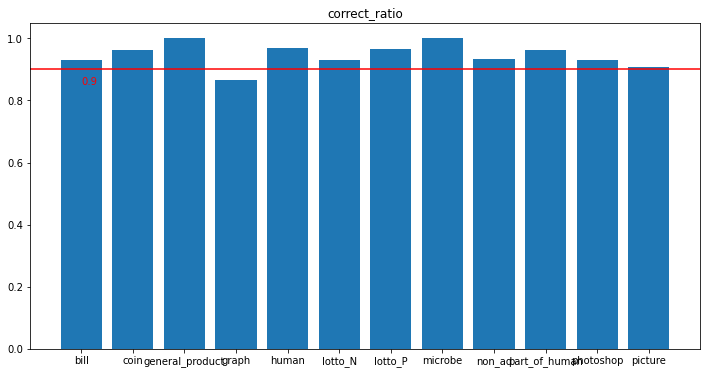

In [22]:
# 각 카테고리별 정확도(정답인 것의 수)
plt.figure(figsize=(12, 6))
plt.axhline(0.9, color='red')
plt.text(0.01, 0.85, '0.9', color='red')
plt.title('correct_ratio')
plt.bar(d.index, d['ratio'])

In [23]:
u = data.loc[data['y'] != data['pred']]

In [24]:
cnt = u['category'].value_counts()
print(cnt)

non_ad           21
graph             4
picture           3
photoshop         2
lotto_N           2
bill              2
human             1
coin              1
part_of_human     1
lotto_P           1
Name: category, dtype: int64


([<matplotlib.patches.Wedge at 0x2174530fa60>,
 [Text(-0.18105397445685548, 1.0849974462335736, 'non_ad'),
  Text(-0.8680546518928156, -0.6756338663264615, 'graph'),
  Text(-0.35716956480232015, -1.04039891482975, 'picture'),
  Text(0.09083711390859571, -1.0962429560716718, 'photoshop'),
  Text(0.4418648169588925, -1.007350725186558, 'lotto_N'),
  Text(0.7450096101456386, -0.8092964109587065, 'bill'),
  Text(0.9208830389998118, -0.6016431072342401, 'human'),
  Text(1.007350595904109, -0.44186511169319176, 'coin'),
  Text(1.0663402541106413, -0.2700341875823381, 'part_of_human'),
  Text(1.0962429294941736, -0.0908374346513204, 'lotto_P')],
 [Text(-0.09875671334010297, 0.5918167888546765, '55.26%'),
  Text(-0.47348435557789936, -0.3685275634507972, '10.53%'),
  Text(-0.19481976261944733, -0.5674903171798636, '7.89%'),
  Text(0.04954751667741584, -0.5979507033118209, '5.26%'),
  Text(0.24101717288666863, -0.5494640319199408, '5.26%'),
  Text(0.4063688782612574, -0.44143440597747624, '5.26

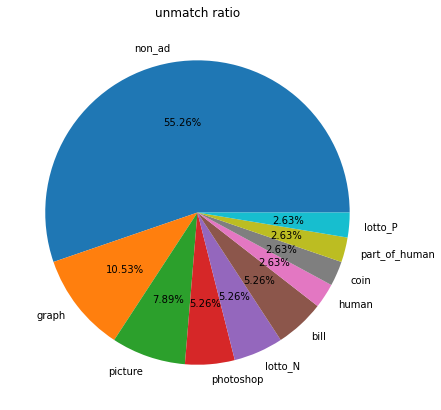

In [25]:
# 오답인 것들 중 각 카테고리의 비율
plt.figure(figsize=(7, 7))
plt.title('unmatch ratio')
plt.pie(cnt.values, labels=cnt.index, autopct='%.2f%%')

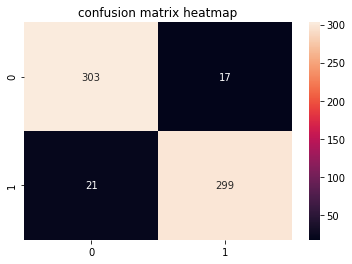

In [27]:
cm = confusion_matrix(y_original, prediction_original, labels=[0,1]) # 0: 광고, 1: 비광고

plt.title('confusion matrix heatmap')
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [28]:
data.to_csv('./test_prediction_with_unmatch.csv')